In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *

In [45]:
# Load Dataset
df = pd.read_csv("data/10sec_100_m_flow_speed_1hr.csv")
df['quarter'] = pd.qcut(df['Space'], q=4, labels=[1, 2, 3, 4])

print(df)

                               Time     Space       Flow    Density  \
0     2022-11-30 14:00:00.400000095  98170.01   45.70200   6.629999   
1     2022-11-30 14:00:00.400000095  98270.01  256.67550  14.329999   
2     2022-11-30 14:00:00.400000095  98370.01  352.75050  11.629999   
3     2022-11-30 14:00:00.400000095  98470.01  116.64000   1.550000   
4     2022-11-30 14:00:00.400000095  98570.01  179.45460   3.849999   
...                             ...       ...        ...        ...   
5755  2022-11-30 14:59:50.400000095  99270.01  104.40432   1.424000   
5756  2022-11-30 14:59:50.400000095  99370.01  183.68568   3.184000   
5757  2022-11-30 14:59:50.400000095  99470.01  290.64600   5.143999   
5758  2022-11-30 14:59:50.400000095  99570.01  226.17072   3.727999   
5759  2022-11-30 14:59:50.400000095  99670.01  335.10240   5.487999   

      y_position_range quarter  
0                  0.0       1  
1                  0.0       1  
2                  0.0       1  
3              

In [46]:
rho_hat = df["Density"]
q_hat = df["Flow"]
C_i = np.mean(sorted(q_hat)[-5:])
print("C_i", C_i)
K = len(rho_hat)

C_i 1807.754939999979


In [47]:
model = ConcreteModel()
model.k = RangeSet(0, K - 1)

# Data parameters
model.rho_hat = Param(model.k, initialize={k: rho_hat[k] for k in range(K)})
model.q_hat = Param(model.k, initialize={k: q_hat[k] for k in range(K)})
model.C = Param(initialize=C_i)  # FIXED

# Variables to optimize
model.rho_crit = Var(bounds=(1e-2, max(rho_hat)), initialize=np.median(rho_hat))
model.V_free = Var(bounds=(10, 150), initialize=60)
model.a = Var(bounds=(0.01, 10), initialize=1.0)

# Smoothed piecewise flow function
def q_pred_expr(model, k):
    rho = model.rho_hat[k]
    rho_crit = model.rho_crit
    V_free = model.V_free
    a = model.a
    Q = rho * V_free * exp(-1/a * (rho/rho_crit)**a)
    return Q

model.q_pred = Expression(model.k, rule=q_pred_expr)

# Objective function
def obj_rule(model):
    return sum((model.q_pred[k] - model.q_hat[k])**2 for k in model.k)

model.obj = Objective(rule=obj_rule, sense=minimize)
print("Initial guess:")
print(f"rho_crit = {value(model.rho_crit)}")
print(f"V_free = {value(model.V_free)}")
print(f"a = {value(model.a)}")

# Solve
solver = SolverFactory('ipopt')
solver.solve(model, tee=True)

rho_crit = value(model.rho_crit)
V_free = value(model.V_free)
a = value(model.a)

# Output
print("Optimized Parameters:")
print(f"rho_crit = {value(model.rho_crit):.3f}")
print(f"V_free = {value(model.V_free):.3f}")
print(f"a = {value(model.a):.3f}")

Initial guess:
rho_crit = 19.8439987
V_free = 60
a = 1.0
Ipopt 3.14.17: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equ

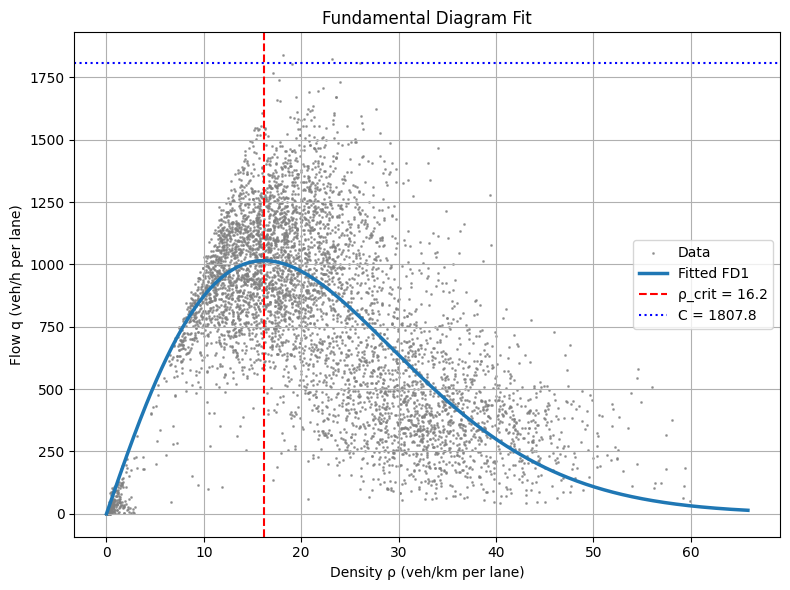

In [48]:
rho_crit = value(model.rho_crit)
V_free = value(model.V_free)
a = value(model.a)
C = np.mean(sorted(q_hat)[-5:])  # same C you used in Pyomo

# Define Q(rho) using the original piecewise FD1
def Q_fd1(rho):
    rho = np.array(rho)
    Q_free = V_free * rho * np.exp(-1/a * (rho / rho_crit)**a)
    # Q = np.where(rho <= rho_crit, Q_free, C)
    Q = Q_free
    return Q

# Generate smooth rho values for curve
rho_range = np.linspace(0, max(rho_hat)*1.1, 500)
q_fit = Q_fd1(rho_range)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(rho_hat, q_hat, color='gray', alpha=0.7, label='Data', s = 1)
plt.plot(rho_range, q_fit, linewidth=2.5, label='Fitted FD1', zorder=10)
plt.axvline(rho_crit, color='red', linestyle='--', label=f'ρ_crit = {rho_crit:.1f}')
plt.axhline(C, color='blue', linestyle=':', label=f'C = {C:.1f}')
plt.xlabel("Density ρ (veh/km per lane)")
plt.ylabel("Flow q (veh/h per lane)")
plt.title("Fundamental Diagram Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
def metanet_param_fit(v_hat, rho_hat, q_hat, v_free, a, rho_crit, T, l, initial_traffic_state, downstream_density, num_calibrated_segments):
    initial_density, initial_velocity, initial_flow_or = initial_traffic_state
    
    print("vhat shape", v_hat.shape)
    num_timesteps, num_segments = v_hat.shape
    
    model = ConcreteModel()
    model.t = RangeSet(0, num_timesteps-1)
    model.i = RangeSet(0, num_segments-1)
    model.segment_ix = RangeSet(0, num_calibrated_segments-1)
    model.num_segments = num_segments
    model.num_timesteps = num_timesteps
    model.num_calibrated_segments = num_calibrated_segments
    # Fixed params
    model.v_free = Param(initialize=v_free)
    model.a = Param(initialize=a)
    model.rho_crit = Param(initialize=rho_crit)
    model.T = Param(initialize=T)
    model.l = Param(initialize=l)

    # Parameters to estimate
    model.eta_high = Var(model.segment_ix, bounds=(0, 10000), initialize=30)
    model.tau = Var(model.segment_ix, bounds=(1e-3, 5.0), initialize=18/3600)
    model.K = Var(model.segment_ix, bounds=(0, 100000), initialize=40)

    # Variables to predict
    model.v_pred = Var(model.t, model.i, bounds=(0, v_free+50))
    model.rho_pred = Var(model.t, model.i, bounds=(1e-3, 300))

    # Observed data
    model.v_hat = Param(model.t, model.i, initialize={(t, i): float(v_hat[t, i]) for t in model.t for i in model.i})
    model.rho_hat = Param(model.t, model.i, initialize={(t, i): float(rho_hat[t, i]) for t in model.t for i in model.i})
    def density_dynamics(current, inflow, outflow, T, l):
        return current + T/(l) * (inflow - outflow)
    
    def calculate_V(m, rho, VSL):
        #V_free * rho * np.exp(-1/a * (rho / rho_crit)**a)
        # exp_term = m.v_free * rho * exp(-1/m.a * (rho/m.rho_crit)**m.a)
        exp_term = m.v_free * exp(-1 / m.a * (rho / m.rho_crit)**m.a)
        return Expr_if(exp_term <= VSL, exp_term, VSL)
    
    def velocity_dynamics(m, current, prev_state, density, next_density, current_density, VSL, T, l, segment_num):
        tau = m.tau[segment_num]
        eta = m.eta_high[segment_num]
        K = m.K[segment_num]
        v_eq = calculate_V(m, density, VSL)
        term1 = T / tau * (v_eq - current)
        term2 = T / l * current * (prev_state - current)
        term3 = (eta * T) / (tau * l) * (next_density - density) / (density + K)
        return current + term1 + term2 - term3
    # Helper function: V(rho)
    def V_eq(m, rho):
        return m.v_free * exp(-1 / m.a * (rho / m.rho_crit)**m.a)

    # Density dynamics
    def rho_update(m, t, i):
        calc_density = 0
        if t == 0:
            for seg in range(num_timesteps):
                m.rho_pred[seg, 0] = initial_density[seg]
            return Constraint.Skip
        if i == 0:
            current = m.rho_hat[t-1,0]
            inflow = initial_flow_or[t-1, 0]
            outflow = m.rho_pred[t-1, i] * m.v_pred[t-1, i]
            calc_density = density_dynamics(current, inflow, outflow, model.T, model.l)
        else:
            current = m.rho_hat[t-1,i]
            inflow = m.rho_pred[t-1, i-1] * m.v_pred[t-1, i-1]
            outflow = m.rho_pred[t-1, i] * m.v_pred[t-1, i]
            calc_density = density_dynamics(current, inflow, outflow, model.T, model.l)
        return m.rho_pred[t,i] == calc_density
    model.rho_dyn = Constraint(model.t, model.i, rule=rho_update)
    VSL = 150
    # Velocity dynamics
    def v_update(m, t, i):
        current_seg_num  = i // (m.num_segments // m.num_calibrated_segments)

        if t == 0:
            for seg in range(num_timesteps):
                m.v_pred[seg, 0] = initial_velocity[seg]
            return Constraint.Skip
        if i == 0:
            current = m.v_pred[t-1, i]
            prev_state = m.v_pred[t-1, i]
            density = m.rho_pred[t-1, i]
            next_density = m.rho_pred[t-1, i+1]
            current_density = m.rho_pred[t, i]
            calc_v = velocity_dynamics(m,current, prev_state, density, next_density, current_density, VSL, model.T, model.l, current_seg_num)
        elif i == num_segments-1:
            current = m.v_pred[t-1, i]
            prev_state = m.v_pred[t-1, i-1]
            density = m.rho_pred[t-1, i]
            next_density = downstream_density[t-1]
            current_density = m.rho_pred[t, i]
            calc_v = velocity_dynamics(m,current, prev_state, density, next_density, current_density, VSL, model.T, model.l, current_seg_num)
        else:
            current = m.v_pred[t-1, i]
            prev_state = m.v_pred[t-1, i-1]
            density = m.rho_pred[t-1, i]
            next_density = m.rho_pred[t-1, i+1]
            current_density = m.rho_pred[t, i]
            calc_v = velocity_dynamics(m, current, prev_state, density, next_density, current_density, VSL, model.T, model.l, current_seg_num)

        return m.v_pred[t,i] == calc_v
    model.v_dyn = Constraint(model.t, model.i, rule=v_update)

    # Objective: minimize squared error between predictions and observations
    def loss_fn(m):
        return sum((m.v_pred[t, i] - m.v_hat[t, i])**2 + (m.rho_pred[t, i] - m.rho_hat[t, i])**2 for t in m.t for i in m.i)
    model.loss = Objective(rule=loss_fn, sense=minimize)

    # Solve
    solver = SolverFactory("ipopt")
    solver.solve(model, tee=True)

    # v_pred_array = np.zeros((num_segments, num_timesteps-1))
    # rho_pred_array = np.zeros((num_segments, num_timesteps-1))
    
    # # Fill arrays with values from the Pyomo model
    # for t in range(1, num_timesteps):  # Pyomo index starts at 1
    #     for i in range(num_segments):
    #         v_pred_array[i, t-1] = value(model.v_pred[t, i])
    #         rho_pred_array[i, t-1] = value(model.rho_pred[t, i])
    # return v_pred_array, rho_pred_array
    return model

In [50]:
# Calculate flow and speed for 100 meter segments
MILE_MARKER_61 = 98170  # meters
# MILE_MARKER_62 = 99779.3  # meters
MILE_MARKER_62 = 99770  # meters
l = 100
space_segments = np.arange(MILE_MARKER_61, MILE_MARKER_62, l)  # 100 meter segments
time_segments = np.arange(0,3600, 10)
num_timesteps = len(time_segments)
num_segments = len(space_segments)
T = 10/3600
l = 0.1
SPEED_LIMIT = 120 # KM/H

rho_hat = np.zeros((len(time_segments), len(space_segments)))
q_hat = np.zeros((len(time_segments), len(space_segments)))
for t in range(len(time_segments)):
    for i in range(len(space_segments)):
        ix_reversed = len(space_segments)-1-i
        rho_hat[t,ix_reversed] = df["Density"][t*len(space_segments) + i]
        if rho_hat[t,ix_reversed] == 0:
            rho_hat[t,ix_reversed] = 1e-3
        q_hat[t,ix_reversed] = df["Flow"][t*len(space_segments) + i]
v_hat = q_hat/ (rho_hat)

num_calibrated_segments = 7

initial_flow = q_hat[:, 0:1]
initial_density = rho_hat[:, 0:1]
initial_velocity = v_hat[:, 0:1]
initial_traffic_state = initial_density, initial_velocity, initial_flow
segment_rho_hat = rho_hat[:, 1:15]       # shape (time, segment)
segment_v_hat = v_hat[:, 1:15]
segment_q_hat = q_hat[:, 1:15]
downstream_density = rho_hat[:, 15:16]

# Transpose before passing
res_model = metanet_param_fit(
    segment_v_hat,
    segment_rho_hat,
    segment_q_hat,
    V_free, a, rho_crit, T, l,
    initial_traffic_state, downstream_density,
    num_calibrated_segments
)
num_timesteps, num_segments = segment_v_hat.shape
print(num_segments, num_timesteps)
v_pred_array = np.zeros((num_timesteps, num_segments))
rho_pred_array = np.zeros((num_timesteps, num_segments))

# Fill arrays with values from the Pyomo model
for t in range(num_timesteps):  # Pyomo index starts at 1
    for i in range(num_segments):
        v_pred_array[t, i] = value(res_model.v_pred[t, i])
        rho_pred_array[t, i] = value(res_model.rho_pred[t, i])

for seg in range(num_calibrated_segments):
    print("Segment", seg)
    print("tau:", value(res_model.tau[seg]))
    print("K:", value(res_model.K[seg]))
    print("eta high", value(res_model.eta_high[seg]))
    print("------------")


vhat shape (360, 14)
Ipopt 3.14.17: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    63902
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    51041

Total number of variables............................:    10101
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    10101
                     variables with only upper bounds:        0
Total number of equality constraints.................: 

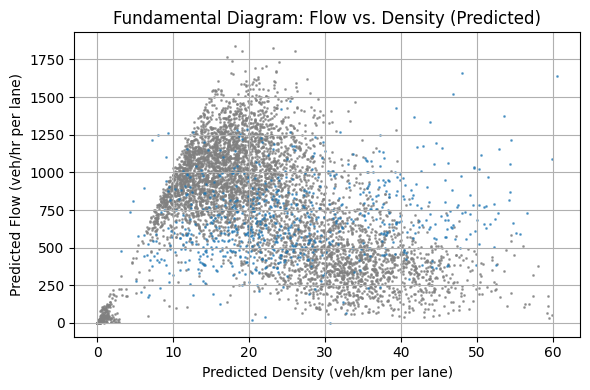

In [61]:
# Extract shape
q_array = rho_pred_array * v_pred_array*4
rho_half = rho_pred_array[:, 8:10].flatten()
q_half = q_array[:, 2:4].flatten()
# Flatten for scatter plot
rho_flat = rho_pred_array.flatten()
q_flat = q_array.flatten()

# Plot
plt.figure(figsize=(6, 4))
# plt.plot(rho_range, q_fit, linewidth=2.5, label='Fitted FD1', zorder=10)
plt.scatter(rho_hat, q_hat, color='gray', alpha=0.7,s = 1, label='Data')
plt.scatter(rho_half, q_half, alpha=0.6, s=1)
plt.xlabel("Predicted Density (veh/km per lane)")
plt.ylabel("Predicted Flow (veh/hr per lane)")
plt.title("Fundamental Diagram: Flow vs. Density (Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()